<a href="https://colab.research.google.com/github/pabloac31/TFG/blob/master/cifar10_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Clone the repository**

In [1]:
! git clone https://github.com/pabloac31/TFG.git
%cd TFG

/content/TFG


**Using Tensorflow v1**

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


**Import libraries**

In [0]:
from cifar10_models import *
from utils import *
from adversarial_attacks import *

**Load models pretrained on CIFAR10**

In [0]:
resnet = resnet50(pretrained=True)
densenet = densenet169(pretrained=True)
mobnet = mobilenet_v2(pretrained=True)
iv3 = inception_v3(pretrained=True)

**Use CUDA if available for faster results**

In [5]:
use_cuda=True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


**Create dataloaders**

Load CIFAR10 test images as tensors of size NxCxHxW normalized with CIFAR10 mean and std.

In [6]:
test_loader = testloader_cifar10('./data', batch_size=256, shuffle=False)  # Dataloader for testing the model 
adv_loader = testloader_cifar10('./data', batch_size=1)                    # Dataloader for adversarial attacks
univ_loader = testloader_cifar10('./data', batch_size=1, shuffle=False)    # Dataloader for universal attack

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


**Test models**

In [9]:
acc = test_model(resnet, device, test_loader)
print('\nAccuracy on CIFAR10 test set: ', acc)

100%|██████████| 40/40 [00:09<00:00,  4.40it/s]


Accuracy on CIFAR10 test set:  0.9212


**Set method parameters**

In [0]:
params_fgsm = {'epsilon': 0.01, 'clip': True}
params_deepfool = {'num_classes': 10, 'overshoot': 0.02, 'max_iter': 50, 'clip': True}

**Test methods**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Succesful attack!


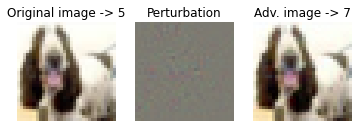

Number of iterations needed:  1


In [42]:
image, label = next(iter(adv_loader))
test_method(resnet, device, image, label, method='deepfool', params=params_deepfool)

**Perform a complete attack and show results**

In [45]:
#params = {'lambda_': 3., 'max_iter': 20, 'epsilon': 0.2, 'delta': 255}
#params = {'target_label': None, 'iters': 10, 'pop_size': 100, 'verbose': True}

adv_examples = attack_model(resnet, device, adv_loader, 'deepfool', params_deepfool)

100%|██████████| 10000/10000 [1:10:38<00:00,  2.36it/s]



======== RESULTS ========
Test Accuracy = 0 / 10000 = 0.0
Average confidence = 0.6835601299215
Average time = 0.4216439959229566
Average magnitude of perturbations = 1.5007586479187012
Model robustness = 0.11480466276407242


In [0]:
v = universal_perturbation(univ_loader, iv3, device, delta=0.1)

plt.imshow(denormalize_cifar10(v[0].cpu().detach().numpy()).transpose((1,2,0)))
plt.title('Universal perturbation')
plt.show()

In [0]:
image = Image.open('./data/img1.png')
x = TF.to_tensor(image)
x = normalize_cifar10(x)
x = x.unsqueeze_(0).to(device)
label = torch.tensor([1]).to(device)
print('Label:', label.item())
x.requires_grad = True
y = iv3(x)
init_pred = y.max(1, keepdim=True)[1]
print("Original image prediction: ", init_pred.item())
x_r = x.add(v).to(device)
pred = iv3(x_r).max(1, keepdim=True)[1]
print("Perturbed image prediction: ", pred.item())

Label: 1
Original image prediction:  1
Perturbed image prediction:  2


In [0]:
img, label = next(iter(adv_loader))
im = denormalize_cifar10(img.numpy()[0].copy()).transpose((1,2,0))
plt.imshow(im)
plt.show()
label = label.item()
success, sol, score = one_pixel_attack(iv3, device, img, label, pop_size=400, iters=20)
print(success)
print(score)
adv = perturb(sol, img)
im = denormalize_cifar10(adv.numpy()[0].copy()).transpose((1,2,0))
plt.imshow(im)
plt.show()

In [0]:
def attack_model(model, device, test_loader, method, params, iters=10000, dataset='cifar10'):

  # Initialize the network and set the model in evaluation mode.
  model = model.to(device).eval()

  # Initialize stat counters
  correct = 0
  incorrect = 0
  confidence = 0
  total_time = 0
  ex_robustness = 0
  model_robustness = 0
  adv_examples = []

  i = 0

  # Loop (iters) examples in test set
  for data, target in pbar(test_loader):
    if i >= iters:
      break
    i += 1

    # Send the data and label to the device
    data, target = data.to(device), target.to(device)

    # Set requires_grad attribute of tensor (important for some attacks)
    if method in ['fgsm', 'deepfool', 'sparsefool']:
        data.requires_grad = True

    # Forward pass the data through the model
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

    # If the initial prediction is wrong, dont botter attacking
    if init_pred.item() != target.item():
      continue

    if method == 'fgsm':
        # Call FGSM attack
        time_ini = time.time()
        perturbed_data, _ = fgsm(model, data, target, output, params["epsilon"], params["clip"], dataset)
        time_end = time.time()
        total_time += time_end-time_ini

    elif method == 'deepfool':
        # Call DeepFool attack
        time_ini = time.time()
        perturbed_data = deepfool(model, device, data, params["num_classes"], params["overshoot"], params["max_iter"])[1]
        time_end = time.time()
        total_time += time_end-time_ini

    elif method == 'sparsefool':
        # Generate lower and upper bounds
        delta = params["delta"]
        lb, ub =  valid_bounds_cifar10(data, delta)
        lb = lb[None, :, :, :].to(device)
        ub = ub[None, :, :, :].to(device)
        # Call SparseFool attack
        time_ini = time.time()
        perturbed_data = sparsefool(model, device, data, target.item(), lb, ub, params["lambda_"], params["max_iter"], params["epsilon"])
        time_end = time.time()
        total_time += time_end-time_ini

    elif method == 'one_pixel_attack':
        # Call one pixel attack
        time_ini = time.time()
        _, best_sol, score = one_pixel_attack(model, device, data, target.item(), params["target_label"], params["iters"], params["pop_size"], params["verbose"])
        perturbed_data = perturb(best_sol, data)
        time_end = time.time()
        total_time += time_end-time_ini


    # Update model robustness
    # multiply by std to make it independent of the normalization used
    difference = de_scale(perturbed_data-data, dataset)
    adv_rob = torch.norm(difference)  # Frobenius norm (p=2)
    #adv_rov = torch.norm(difference, float('inf'))  # Inf norm (p=inf)
    ex_robustness += adv_rob
    model_robustness += adv_rob / torch.norm(de_scale(data, dataset))
    #model_robustness += adv_rob / torch.norm(de_scale(data, dataset), float('inf'))

    # Re-classify the perturbed image
    output = model(perturbed_data)

    # Check for success
    final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    
    if final_pred.item() == target.item():
      correct += 1
    
    else:
      incorrect += 1
      # Update average confidence
      confidence += F.softmax(output, dim=1).max(1, keepdim=True)[0].item()  
      # Save some adv examples for visualization later
      if len(adv_examples) < 5:
        adv_examples.append( (init_pred.item(), final_pred.item(), data.detach().cpu(), perturbed_data.detach().cpu()) )

  # Calculate stats
  final_acc = correct / float(iters)  # len(test_loader)
  avg_confidence = confidence / float(incorrect)
  avg_time = total_time / float(correct+incorrect)
  avg_ex_robustness = ex_robustness / float(correct+incorrect)
  model_robustness = model_robustness / float(correct+incorrect)
  print("\n======== RESULTS ========")
  print("Test Accuracy = {} / {} = {}\nAverage confidence = {}\nAverage time = {}\nAverage magnitude of perturbations = {}\nModel robustness = {}"
    .format(correct, iters, final_acc, avg_confidence, avg_time, avg_ex_robustness, model_robustness))

  # Return adversarial examples
  return adv_examples

In [0]:
def test_method(model, device, img, label, method, params):

  model = model.to(device).eval()

  x = img.to(device)
  label = label.to(device)

  x.requires_grad = True

  y = model(x)
  init_pred = y.max(1, keepdim=True)[1]

  if init_pred.item() != label.item():
    print("Wrong classification...")
    return

  # Call method
  if method == 'fgsm':
    adv_x, pert_x = fgsm(model, x, label, y, params["epsilon"], params["clip"])

  elif method == 'deepfool':
    _, adv_x, pert_x, n_iter = deepfool(model, device, x, params["num_classes"], params["overshoot"], params["max_iter"])

  elif method == 'sparsefool':
    # Generate lower and upper bounds
    delta = params["delta"]
    lb, ub =  valid_bounds_cifar10(data, delta)
    lb = lb[None, :, :, :].to(device)
    ub = ub[None, :, :, :].to(device)
    adv_x = sparsefool(model, device, data, target.item(), lb, ub, params["lambda_"], params["max_iter"], params["epsilon"])

  elif method == 'one_pixel_attack':
    _, best_sol, score = one_pixel_attack(model, device, data, target.item(), params["target_label"], params["iters"], params["pop_size"], params["verbose"])
    adv_x = perturb(best_sol, data)

  y_adv = model(adv_x)
  adv_pred = y_adv.max(1, keepdim=True)[1]

  if adv_pred.item() == label.item():
    print("Attack failed...")

  else:
    print("Succesful attack!")

  f = plt.figure()
  f.add_subplot(1,3,1)
  plt.title('Original image -> ' + str(label.item()))
  plt.axis('off')
  plt.imshow(displayable(img))
  f.add_subplot(1,3,2)
  plt.title('Perturbation')
  plt.axis('off')
  plt.imshow(displayable(pert_x.cpu().detach()))
  f.add_subplot(1,3,3)
  plt.title('Adv. image -> ' + str(adv_pred.item()))
  plt.axis('off')
  plt.imshow(displayable(adv_x.cpu().detach()))
  plt.show(block=True)

  if method == 'deepfool':
    print('Number of iterations needed: ', n_iter)

In [0]:
def deepfool(model, device, image, num_classes=10, overshoot=0.02, max_iter=50, clip=False, dataset='cifar10'):

  # Get the output of the original image
  output = model(image)
  # Get the input image shape
  input_shape = image.size()
  # Array with the class probabilities of the image
  f_image = output.data.cpu().numpy().flatten()
  # Classes ordered by probability (descending)
  I = f_image.argsort()[::-1]
  # We consider only 'num_classes' classes
  I = I[0:num_classes]
  # Get the predicted label
  label = I[0]

  # Start from a copy of the original image
  pert_image = copy.deepcopy(image)   # tensor of size (1,3,H,W)

  # Initialize variables
  r_tot = torch.zeros(input_shape).to(device) # adversarial perturbation
  k_i = label  # current label
  loop_i = 0

  while k_i == label and loop_i < max_iter:

    # Get the output for the current image
    x = pert_image.clone().detach().requires_grad_(True)
    fs = model(x)

    pert = torch.Tensor([np.inf])[0].to(device)
    w = torch.zeros(input_shape).to(device)

    # Calculate grad(f_label(x_i))
    fs[0, I[0]].backward(retain_graph=True)
    grad_orig = grad_orig = copy.deepcopy(x.grad.data)

    for k in range(1, num_classes):  # for k != label
      # Reset gradients
      zero_gradients(x)

      # Calculate grad(f_k(x_i))
      fs[0, I[k]].backward(retain_graph=True)
      cur_grad = copy.deepcopy(x.grad.data)

      # Set new w_k and new f_k
      w_k = cur_grad - grad_orig
      f_k = (fs[0, I[k]] - fs[0, I[0]]).data

      # Calculate hyperplane-k distance
      pert_k = torch.abs(f_k) / w_k.norm()  # Frobenious norm (2-norm)

      # determine which w_k to use
      if pert_k < pert:
        pert = pert_k + 0.
        w = w_k + 0.

    # compute r_i and r_tot
    r_i = torch.clamp(pert, min=1e-4) * w / w.norm()  # Added 1e-4 for numerical stability
    r_tot = r_tot + r_i

    # Update perturbed image
    pert_image = pert_image + r_i  # x_(i+1) <- x_i + r_i

    # Adding overshoot
    std = std_cifar10 if dataset=='cifar10' else [1,1,1]
    #check_fool = image + (1 + overshoot) * r_tot
    check_fool = copy.deepcopy(image)
    check_fool[0][0] += (1 + overshoot/std[0]) * r_tot[0][0]
    check_fool[0][1] += (1 + overshoot/std[1]) * r_tot[0][1]
    check_fool[0][2] += (1 + overshoot/std[2]) * r_tot[0][2]

    x = check_fool.clone().detach().requires_grad_(True)
    # output for x_(i+1)
    fs = model(x)
    # label assigned to x_(i+1)
    k_i = torch.argmax(fs.data).item()

    loop_i += 1

  # Compute final perturbed image output
  x = pert_image.clone().detach().requires_grad_(True)
  fs = model(x)
  # Compute final gradient
  (fs[0, k_i] - fs[0, label]).backward(retain_graph=True)
  grad = copy.deepcopy(x.grad.data)
  grad = grad / grad.norm()

  # Include lambda_fac in the adversarial perturbation
  #r_tot = lambda_fac * r_tot
  r_tot[0][0] *= 1 + (overshoot / std[0])
  r_tot[0][1] *= 1 + (overshoot / std[1])
  r_tot[0][2] *= 1 + (overshoot / std[2])
  # Update adverarial image (pert_image = image + r_tot)
  p_im = image.detach().cpu().numpy() + r_tot.detach().cpu().numpy() # for deepcopy
  pert_image = torch.from_numpy(p_im).to(device)

  # Adding clipping to maintain [0,1] range
  if clip:
    pert_image = clamp(image + r_tot, 0, 1, dataset)

  return grad, pert_image, r_tot, loop_i